In [23]:
import matplotlib.pylab as plt

In [24]:
% matplotlib inline 

In [25]:
import scipy.signal as signal
import numpy as np 
import os, csv

In [26]:
def load_data(day=1, subject_id='12', listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)
                
    for file_name in data_file_names: 
        if subject_id in file_name: 
            subject_path = data_path + file_name
            if listen: print("loading data from subject'%s'"%file_name) 

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: dictionary containing np.arrays of pupil, CS+, CS-, and US data 
    
    """

    pupil  = []           # pupil 
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]        

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            pupil.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)

        except:            

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: us_o = 1
                if 'OFF' in msg[1]: cs_p = cs_n = us_o = 0 

    data = {'pupil':np.array(pupil), 'CS+':np.array(cs_pos), 'CS-':np.array(cs_neg), 'US':np.array(us_sti)}

    return np.array(pupil), data


def find_derivative(pupil_data): 
    """determined the change in pupil size across an interval set by 'skip'"""

    # initiate data structures
    indices = []
    skip = 5 
    dp_dt = np.zeros(len(pupil_data))

    # define blink as time when no measurements taken--super conservative
    blink_segment = np.repeat(np.nan, len(pupil_data))
    blink_segment[pupil_data==0] = 1 * np.mean(pupil_data)

    # take interval if we're subsampling the data (to get bigger deltas)
    sliced_segment = pupil_data[::skip]
    index_segment = np.array(list(range(len(pupil_data)))[0::skip])

    # preserve the length of the segment, even if we're subsampling
    for ii in range(1, len(sliced_segment)): 
        dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

    return abs(dp_dt), blink_segment


def define_blinks(pupil_data): 
    """determine when blinks occur in timecourse"""

    set_thresh = 500
    conv_filter_length=20
    
    blink = np.repeat(np.nan, len(pupil_data))
    
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = find_derivative(pupil_data)

    # fill zero space inside derivative with arbitrary value (to sum later)
    delta[naive_blink==naive_blink] = 1
    
    # another way to do this is to add the colvolution of naive and delta together -- more interpretable
    _delta_ = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]

    # inherit naive locations
    blink[naive_blink > 0] = 1

    # inherit edges  
    blink[_delta_ > set_thresh] = 1
    
    # ? tyler ? 
    blink[blink == blink] = 1
    
    return blink, pupil_data


def find_boundaries(blink_zero):
    
    # convert to zeros if was nan
    if blink_zero[0] != blink_zero[0]: 
        blink_zero[blink_zero!=blink_zero] = 0 
    
    # convolve with an edge detector 
    kernel = [1,-1]
    edges = np.convolve(blink_zero, kernel)
    
    # find location of onsets and offsets in the timecourse
    onsets, offsets = np.nonzero(edges > 0 )[0], np.nonzero(edges < 0)[0]
    
    return onsets, offsets


def interpolate(y_data, blink, window_size=5, show=0, order=5): 
    """
    y_data = vector  
    blink
    window_size=5
    show=0
    """
    # generate indices for pupil measurements
    x_range = np.arange(len(y_data))
    
    # identify "blink" onsets and offsets
    onsets, offsets = find_boundaries(blink)

    # generate data structure for blink fills 
    poly_fill_blinks = np.repeat(np.nan, len(x_range))
    poly_edge_blinks = np.repeat(np.nan, len(x_range))
    
    # edge around blink to include in polynomial fit 
    window_size = window_size 
    
    if show: plt.figure(figsize=[15,4]) 
        
    for i_blink in range(len(offsets)): 

        # define n_inds to include around "blink"
        poly_fit_ons = onsets[i_blink] - window_size 
        poly_fit_off = offsets[i_blink] + window_size

        # extract interval polynomial will be fit to
        x_short = x_range[poly_fit_ons:poly_fit_off]
        y_short = y_data[poly_fit_ons:poly_fit_off]

        # find polynomial fit to window around "blink" 
        edge_function = np.polyfit(x_short[y_short==y_short], y_short[y_short==y_short], order)
        function_ = np.poly1d(edge_function)
        i_fill_blink = function_(x_short)[window_size:-window_size]

        poly_fill_blinks[onsets[i_blink]:offsets[i_blink]] = i_fill_blink
        poly_edge_blinks[poly_fit_ons:poly_fit_off] = y_data[poly_fit_ons:poly_fit_off]

        if show: 

            empty_set_ref = np.repeat(np.nan, len(x_range))
            empty_set_ref[poly_fit_ons:poly_fit_off] = y_data[poly_fit_ons:poly_fit_off]
            empty_set_poly = np.repeat(np.nan, len(x_range))
            empty_set_poly[onsets[i_blink]:offsets[i_blink]] = i_fill_blink

            plt.subplot(1,2,i_blink+1)
            plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
            plt.scatter(x_range[empty_set_ref==empty_set_ref],empty_set_ref[empty_set_ref==empty_set_ref], marker='o', s=20)

            plt.plot(x_range, empty_set_poly, 'm', alpha=.5, linewidth=5)

            plt.legend(['   "pupil" data', '  polynomial fit', 'edges used to \n fit polonomial'], prop={'size': 10})
            plt.title("polynomial fit to 'blink' %s\n"%i_blink);
            plt.axis('off')

    return poly_fill_blinks, poly_edge_blinks


def filter_data(input_data, start_int=0, len_int=10000, filter_order=2, lowpass_cutoff=0.00001, highpass_cutoff=.01, show=0): 
    
    # First, design the Buterworth filter to extract lowest frequency variation - a better mean, basically, to subtract
    B_1, A_1= signal.butter(filter_order, lowpass_cutoff, output='ba') 
    low_freq = signal.filtfilt(B_1,A_1, input_data)

    # extract the frequency range of likely motion artifacts
    B_2, A_2 = signal.butter(filter_order, highpass_cutoff, output='ba') 
    below_high = signal.filtfilt(B_2, A_2, input_data)
    filtered_data = below_high - low_freq

    # zscore the filtered data
    filtered_data = (filtered_data-np.mean(filtered_data))/np.std(filtered_data)
    
    if start_int: 
        end_int = start_int + len_int
    else: 
        start_int = 0
        end_int = len(input_data)
        

    def slice_data(data_in,start_int, end_int): 
        return data_in[start_int:start_int+end_int]
    
    _filter_ = {}
    _filter_['input_data'] = input_data = slice_data(input_data, start_int, end_int)
    _filter_['low_freq'] = low_freq = slice_data(low_freq, start_int, end_int)
    _filter_['below_high'] = below_high = slice_data(below_high, start_int, end_int)
    _filter_['filtered_data'] = filtered_data = slice_data(filtered_data, start_int, end_int)
    
    if show: 
        plt.figure(figsize=(20,3)); plt.axis('off'); 
        plt.plot(input_data, 'xkcd:blue',alpha=.4, linewidth=3)
        plt.plot(low_freq, 'xkcd:red',alpha=.2,linewidth=6)
        plt.plot(below_high,'indigo',linewidth=1,alpha=.7)
        plt.legend(['original','low pass filter','high pass filtered'])
        plt.title('bandpass procedure on blink corrected pupil data')
        plt.figure(figsize=(20,3)); plt.axis('off'); 
        plt.ylim([min(filtered_data)-.25,max(filtered_data)+.25]); 
        plt.xlim([0,len(filtered_data)])  
        plt.plot(filtered_data,'indigo',linewidth=3,alpha=.7,color='xkcd:blue')
        plt.title('\noutput: bandpass filtered data')
    
    return _filter_


In [27]:
def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])

In [28]:
# extract data
subject_data = load_data()
pupil_data, data = extract_data(subject_data)

# define blink times
blinks, pupil = define_blinks(pupil_data)

# extract onsets and offsets
onsets, offsets = find_boundaries(blinks)

# set polynomial order 
order = 0

# set blinks to NaNs
pupil[blinks==1] = np.nan

# interpolate betwen blinks
poly_fill, poly_edges = interpolate(pupil, blinks, window_size=20, order=order)

# fill gaps 
pupil[poly_fill == poly_fill] = poly_fill[poly_fill == poly_fill]

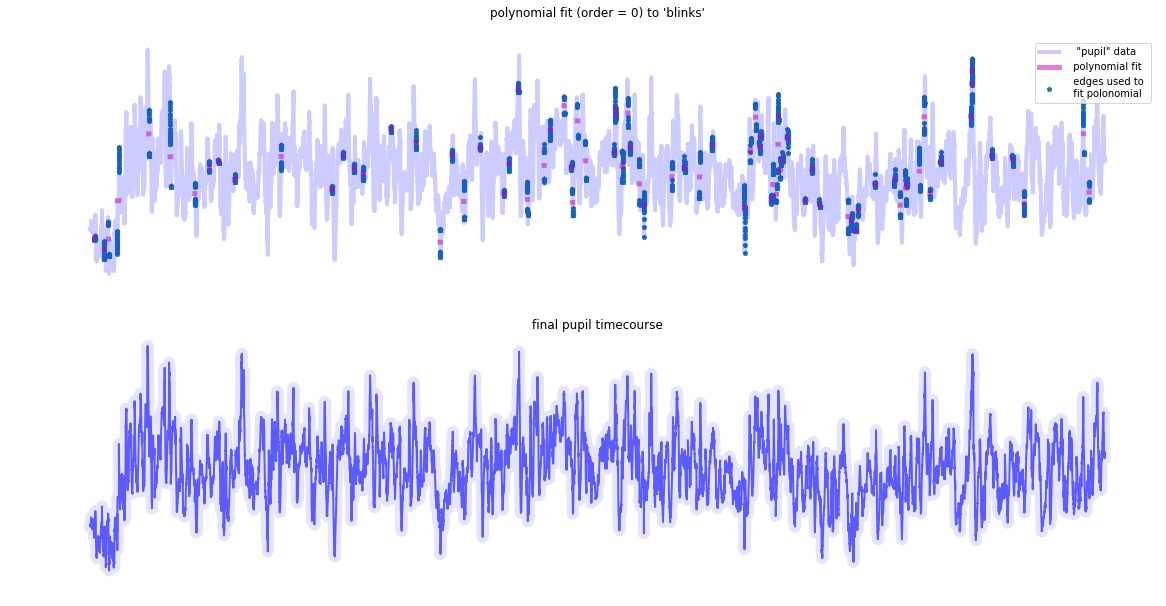

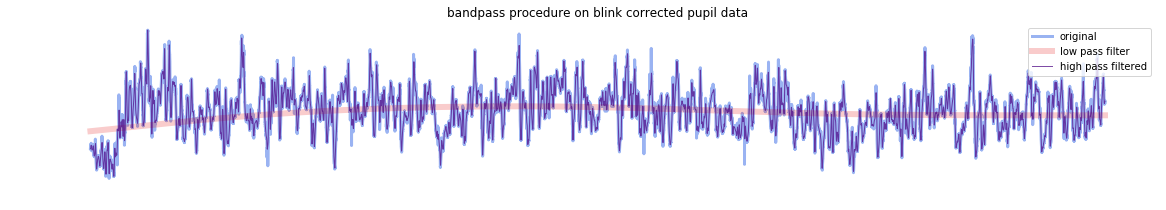

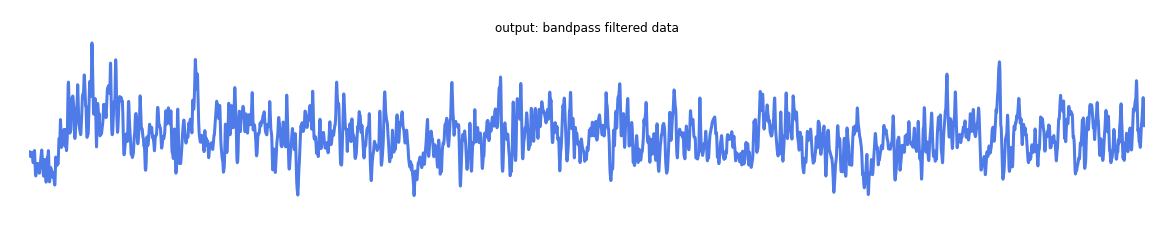

In [29]:
# use old naming for plot convenience
x_range = np.arange(0, len(pupil))
y_data = np.copy(pupil)

# visualize 
plt.figure(figsize=[20,10])
plt.subplot(2,1,1); plt.axis('off'); 
# plot original data (without the blink)
plt.plot(x_range, pupil, 'b', alpha=.2, linewidth=4)
# plot the edges used to generate interpolation
plt.scatter(x_range[poly_edges==poly_edges],poly_edges[poly_edges==poly_edges], marker=(5, 0), s=20)
# plot interpolation between edges
plt.plot(x_range, poly_fill, 'm', alpha=.5, linewidth=5)
# aesthetics 
plt.legend(['   "pupil" data', '  polynomial fit', '  edges used to \n  fit polonomial'], prop={'size': 10}, loc=1)
plt.title("polynomial fit (order = %s) to 'blinks'\n"%order);

# visualize blink corrected timecourse
plt.subplot(2,1,2) ; plt.axis('off'); 
nice_lines(pupil, color='b', name='') 
plt.title('final pupil timecourse')
_filter_ = filter_data(pupil, show=1)

In [ ]:
% matplotlib inline 
import os, csv
import numpy as np
import matplotlib.pylab as plt

In [ ]:
def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])

In [ ]:

def load_subject():
    """loads eyelink-converted asc files containing"""

    data_path = '../../collection/gaze_data/'
    i_subject = 12
    
    data_file_names = []
    folder_contents = os.listdir(data_path)

    for file in folder_contents: 
        if 'd1.asc' in file and not 'x' in file: 
            data_file_names.append(file)

    subject_path = data_path + data_file_names[i_subject]
    print('collecting gaze data from: ' + subject_path)

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)
    
    return subject_data

def extract_pupil_data(): 
    """extracts pupil size from eyelink-converted converted asc files"""

    # initialize data structures and load data
    pupil_data = []
    pupil_column = 3 
    subject_data = load_subject() 

    # extract pupil diameter from data file 
    for i_row in range(len(subject_data)): 
        try: 
            int(subject_data[i_row][0])
            i_pupil = subject_data[i_row][pupil_column]
            pupil_data.append(float(i_pupil))
        except: 
            pass 

    # save pupil data to class instance
    return np.array(pupil_data)


def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: dictionary containing np.arrays of pupil, CS+, CS-, and US data 
    
    """

    pupil  = []           # pupil 
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]        

        try: 
            int(msg[0])
            # 3 = pupil column
            datum = float(msg[3]) 
            pupil.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)

        except:            

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: us_o = 1
                if 'OFF' in msg[1]: cs_p = cs_n = us_o = 0 

    data = {'pupil':np.array(pupil), 'CS+':np.array(cs_pos), 'CS-':np.array(cs_neg), 'US':np.array(us_sti)}

    return np.array(pupil), data





def dpupil_dtime(pupil_data): 
    """determined the change in pupil size across an interval set by 'skip'"""

    # initiate data structures
    indices = []
    skip = 5 
    dp_dt = np.zeros(len(pupil_data))

    # define blink as time when no measurements taken--super conservative
    blink_segment = np.repeat(np.nan, len(pupil_data))
    blink_segment[pupil_data==0] = 1 * np.mean(pupil_data)

    # take interval if we're subsampling the data (to get bigger deltas)
    sliced_segment = pupil_data[::skip]
    index_segment = np.array(list(range(len(pupil_data)))[0::skip])

    # preserve the length of the segment, even if we're subsampling
    for ii in range(1, len(sliced_segment)): 
        dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

    return abs(dp_dt), blink_segment


def find_blinks(pupil_data): 
    """determine when blinks occur in timecourse"""

    set_thresh = 500
    conv_filter_length=20
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = dpupil_dtime(pupil_data)

    # convolve, etc.
    delta[naive_blink==naive_blink] = 1
    wide_delta = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]
    blink = np.repeat(np.nan, len(pupil_data))
    blink[wide_delta > set_thresh] = 1
    blink[naive_blink > 0] = 1

    blink[blink == blink] = 1
    return blink, pupil_data


In [ ]:
def search_blinks(blink_zero):
    
    if blink_zero[0] != blink_zero[0]: 
        blink_zero[blink_zero!=blink_zero] = 0 
    
    # convolve with an edge detector 
    kernel = [1,-1]
    edges = np.convolve(blink_zero, kernel)
    # find location of onsets and offsets in the timecourse
    onsets, offsets = np.nonzero(edges > 0 )[0], np.nonzero(edges < 0)[0]
    
    return onsets, offsets

In [ ]:
def polynomial_fill_blinks(y_data, blink, window_size=5, show=0, order=5): 
    """
    y_data = vector  
    blink
    window_size=5
    show=0
    """
    # generate indices for pupil measurements
    x_range = np.arange(len(y_data))
    
    # identify "blink" onsets and offsets
    onsets, offsets = search_blinks(blink)

    # generate data structure for blink fills 
    poly_fill_blinks = np.repeat(np.nan, len(x_range))
    poly_edge_blinks = np.repeat(np.nan, len(x_range))
    
    # edge around blink to include in polynomial fit 
    window_size = window_size 
    
    if show: plt.figure(figsize=[15,4]) 
        
    for i_blink in range(len(offsets)): 

        # define n_inds to include around "blink"
        poly_fit_ons = onsets[i_blink] - window_size 
        poly_fit_off = offsets[i_blink] + window_size

        # extract interval polynomial will be fit to
        x_short = x_range[poly_fit_ons:poly_fit_off]
        y_short = y_data[poly_fit_ons:poly_fit_off]

        # find polynomial fit to window around "blink" 
        edge_function = np.polyfit(x_short[y_short==y_short], y_short[y_short==y_short], order)
        function_ = np.poly1d(edge_function)
        i_fill_blink = function_(x_short)[window_size:-window_size]

        poly_fill_blinks[onsets[i_blink]:offsets[i_blink]] = i_fill_blink
        poly_edge_blinks[poly_fit_ons:poly_fit_off] = y_data[poly_fit_ons:poly_fit_off]

        if show: 

            empty_set_ref = np.repeat(np.nan, len(x_range))
            empty_set_ref[poly_fit_ons:poly_fit_off] = y_data[poly_fit_ons:poly_fit_off]
            empty_set_poly = np.repeat(np.nan, len(x_range))
            empty_set_poly[onsets[i_blink]:offsets[i_blink]] = i_fill_blink

            plt.subplot(1,2,i_blink+1)
            plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
            plt.scatter(x_range[empty_set_ref==empty_set_ref],empty_set_ref[empty_set_ref==empty_set_ref], marker='o', s=20)

            plt.plot(x_range, empty_set_poly, 'm', alpha=.5, linewidth=5)

            plt.legend(['   "pupil" data', '  polynomial fit', 'edges used to \n fit polonomial'], prop={'size': 10})
            plt.title("polynomial fit to 'blink' %s\n"%i_blink);
            plt.axis('off')

    return poly_fill_blinks, poly_edge_blinks

In [ ]:
# extract data
subject_data = load_subject()
pupil_data, _ = extract_data(subject_data)

#pupil_data = extract_pupil_data()
# select an interval 
onset, offset = 2500, 6000

# define blink times
blinks, pupil = find_blinks(pupil_data)
pupil, blinks = pupil[onset:offset], blinks[onset:offset]

# extract onsets and offsets
onsets, offsets = search_blinks(blinks)

# set polynomial order 
order = 1

# set blinks to NaNs
pupil[blinks==1] = np.nan

# interpolate betwen blinks
poly_fill, poly_edges = polynomial_fill_blinks(pupil, blinks, window_size=20, order=order)

# use old naming for plot convenience
x_range = np.arange(0, len(pupil))
y_data = np.copy(pupil)

# fill gaps 
pupil[poly_fill == poly_fill] = poly_fill[poly_fill == poly_fill]

In [ ]:
# visualize steps
plt.figure(figsize=[20,10])
plt.subplot(2,1,1); plt.axis('off'); 
# plot original data (without the blink)
plt.plot(x_range, y_data, 'b', alpha=.2, linewidth=4)
# plot the edges used to generate interpolation
plt.scatter(x_range[poly_edges==poly_edges],poly_edges[poly_edges==poly_edges], marker=(5, 0), s=20)
# plot interpolation between edges
plt.plot(x_range, poly_fill, 'm', alpha=.5, linewidth=5)
# aesthetics 
plt.legend(['   "pupil" data', '  polynomial fit', '  edges used to \n  fit polonomial'], prop={'size': 10}, loc=1)
plt.title("polynomial fit (order = %s) to 'blinks'\n"%order);

# visualize blink corrected timecourse
plt.subplot(2,1,2) ; plt.axis('off'); 
nice_lines(pupil, color='b', name='') 
plt.title('final pupil timecourse')